## What We'll Do In This Notebook

This notebook is to help you see how you might approach a regression problem. This won't be lectured on, it is just for you to have as a reference for Notebook 8.

This material is adapted from the book <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/">Hands-On Machine Learning with Scikit-Learn and TensorFlow</a>. This is an excellent book and a useful reference if you're looking to purchase a book about machine learning with python.

In [1]:
# Import packages

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

# Predicting California Housing Prices

In this notebook we'll build a regression model to predict 1990 California Census block median housing values. This is just meant to give some guidance on how you might get started in a regression problem. We won't be finding the best model for this data, but you could easily build upon what is presented to get to the best model. Think of this notebook as a jumping off point for Notebook 8.

Let's first load the data.

In [2]:
# Read the data
df = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv")

We'll now briefly explore the data.

In [3]:
# Let's look at the first 5 rows
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# As well as the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


So we have a dataframe with $20640$ rows. All of the columns are numerical except for `ocean_proximity`, which is a qualitative variable.

Also notice that `total_bedrooms` has $207$ missing values, this is the first time we've encountered this issue so we'll see how to deal with that soon. Let's explore the data a bit more.

In [5]:
# What kind of categories are possible for ocean proximity?
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# What percent of the category is each value?
df.ocean_proximity.value_counts(normalize=True)

<1H OCEAN     0.442636
INLAND        0.317393
NEAR OCEAN    0.128779
NEAR BAY      0.110950
ISLAND        0.000242
Name: ocean_proximity, dtype: float64

In [7]:
# let's use describe to look at the remaining values
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


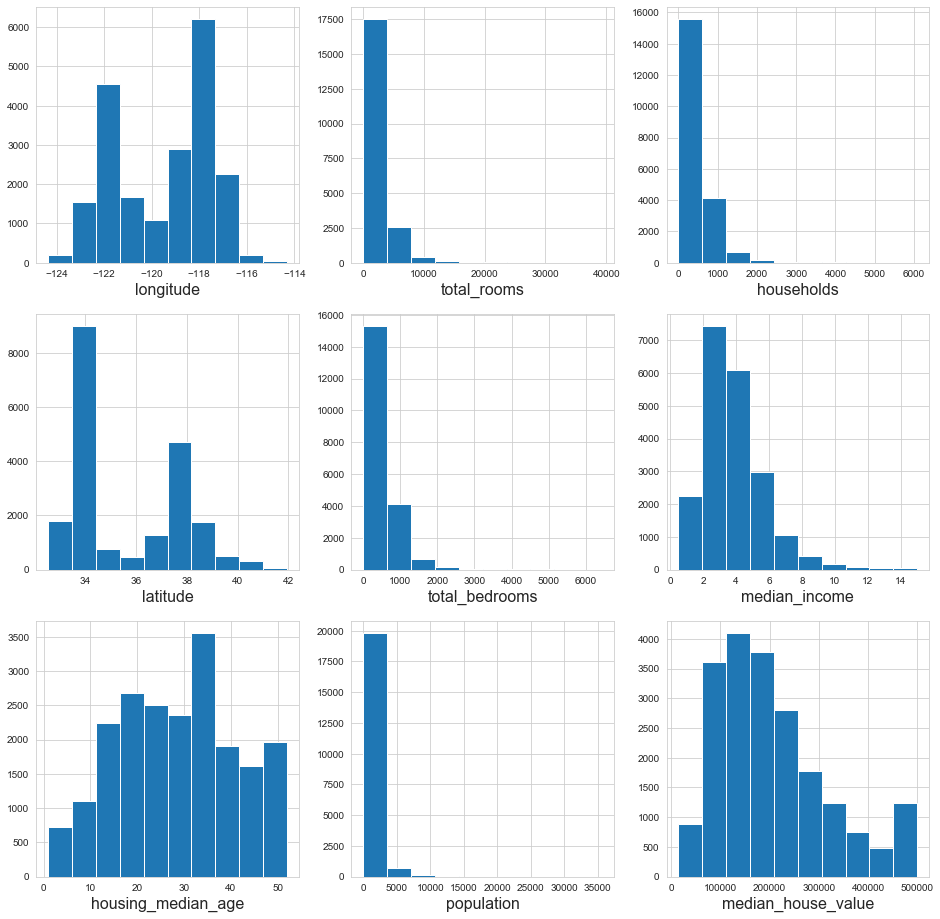

In [8]:
# Finally let's look at a histogram for all the numeric 
# variables
columns = df.describe().columns

fig,ax = plt.subplots(3,3,figsize=(16,16))

for i in range(len(columns)):
    ax[i%3, i//3].hist(df[columns[i]])
    
    ax[i%3, i//3].set_xlabel(columns[i],fontsize=16)
    
plt.show()

We should notice several things.

<ol>
    <li>median_income is not measured in US dollars. It turns out that the people who prepared this data capped low income at $0.05$ and high income at $15$.</li>
    <li>median_house_value is also capped at $500000$. This is troublesome because we want to predict median_house_value. Either we'll have to go to the people that gave us the data to get accurate values (which we cannot do in this instance), or we'll have to remove these instances from the data set because it will mess up our prediction.</li>
    <li>The scales of our data are quite different, luckily we just learned about feature scaling in Notebook 6.</li>
    <li>A number of our features have skewed distributions, which makes it difficult for our regression algorithms to predict well.</li>
    <li>For ocean_proximity only $5$ observations are classified as ISLAND, this is so rare that we might want to think about whether or not to include these $5$ samples in the model. Perhaps it is best to exclude them and then build a different simple model for the ISLAND observations.</li>
</ol>

We have tools to address these issues so let's get started.

For this notebook we'll remove the $500,000$ `median_house_value` observations.

In [9]:
df = df.drop(df.loc[df.median_house_value >= 500000,].index)

And we'll drop the $5$ ISLAND observations.

In [10]:
df = df.drop(df.loc[df.ocean_proximity == 'ISLAND',].index)

Now we'll perform a train test split.


### Train Test Split

We could go about creating our train test split with entirely random sampling, but that probably won't do well with this data set. 

It is reasonable to assume that `median_income` is likely to impact `median_house_value`. If we perform entirely random sampling to produce the train test split it is quite probable that we will not include high values of `median_income` in our training set. However, if we want our algorithm to generalize well we need the training data to have some of these values.

For example, if you wanted to know who Americans were likely to vote for in November you probably wouldn't survey only men. The best survey techniques strive to have a survey sample that reflects the make up of the population, meaning close to a $50$-$50$ split in gender.

One way to ensure that we get a good sample for the training data is to use a <i>stratified train test split</i>. This is done using a categorical variable. Let's say you want to use variable $A$ and $A$ has two categories. Category $1$ is $30\%$ of the data and category $2$ is $70\%$ of the data. If you want a train split containing a random sample of $75\%$ of the entire data set you go into all the observations labeled $1$ by variable $A$ and select $75\%$ of them randomly. Then you go into all the observations labeled $2$ by variable $A$ and slect $75\%$ of those randomly. In this way you've selected $75\%$ of the data, but in a way so that the train and test sets still have a $30$-$70$ split for variable $A$.

Okay let's put this to work for `median_income`

##### First Create a Categorical Variable

In [11]:
# divide the median_income by 1.5, take the ceiling
df['med_income_cat'] = np.ceil(df['median_income']/1.5)

# combine all observations greater than 5, and
# reassign as 5
df.loc[df.med_income_cat > 5, 'med_income_cat'] = 5

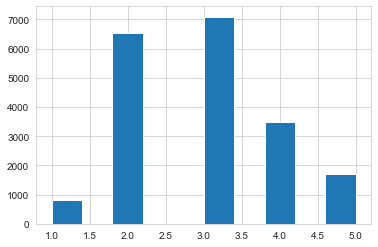

In [12]:
# Look at the categorical split
df.med_income_cat.hist()
plt.show()

##### Now Use the Categorical Variable for Stratified Split

In [13]:
# sklearn has a great train_test_split
from sklearn.model_selection import train_test_split

In [14]:
# First input what you want split, either a dataframe or np.array
# then set the train size
# if you want to stratify enter the column you want to stratify by
# finally include a random state to be able to reproduce your split
df_train,df_test = train_test_split(df.copy(), train_size=.75, 
                                    stratify=df['med_income_cat'], 
                                    random_state = 614)

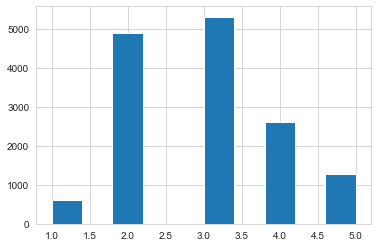

In [15]:
# Let's check the split 
df_train.med_income_cat.hist()

plt.show()

## Diving Deeper into the Data

Now that we have a training set we can do a deeper dive into the data to look for relationships between the target, `med_house_value`, and the features.

### Looking at the Data Spatially

Let's first examine the median housing value as a function of both `latitude` and `longitude`.

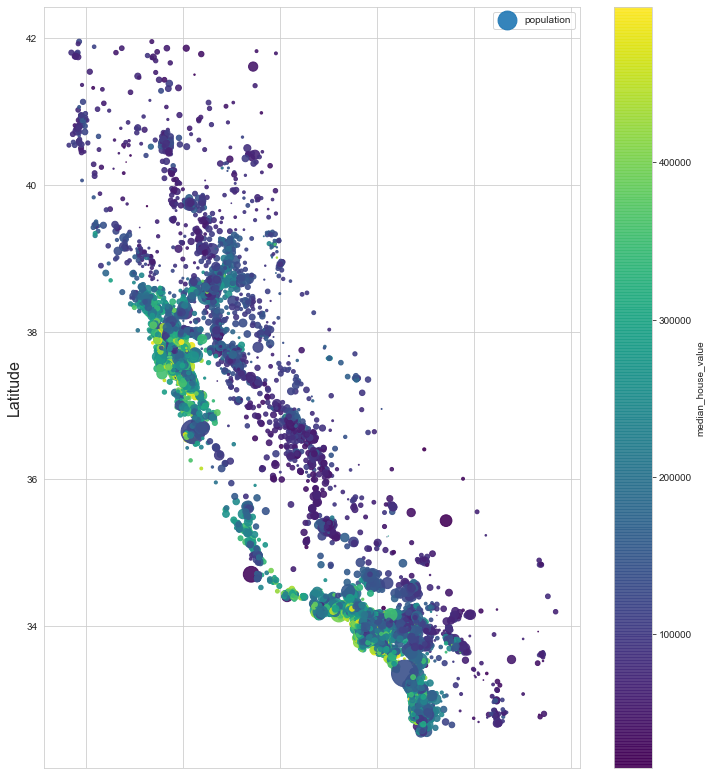

In [16]:
# Each dot is at it's longitude and latitude
# the size of the dot is proportional to its population
# the color of the dot represents the median_house_value of the dot
df_train.plot(kind="scatter", x = "longitude", y = "latitude",
             alpha = .9, s = df_train["population"]/50, label="population",
             figsize=(12,14), c="median_house_value",cmap = plt.get_cmap("viridis"), 
             colorbar=True)

plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

plt.show()

It is hard to tell what affect population may have on the median value, but this shows us that housing value is definitely related to where in the state the census district is located. Location, location location!

It appears that more valuable housing districts occur along the coast, and for a given latitude as you move east you tend to decrease in median value. However, this pattern doesn't hold near Sacramento which is slightly above $38$ latitude. So there is probably some other data we could add to the model like, <i>close to a city</i>, or something that could improve upon the given data. Another thought would be to delve into the realm of spatial statistics, however that is out of the scope of our given course.

One way we may capture this trend is to include the `ocean_proximity` feature.

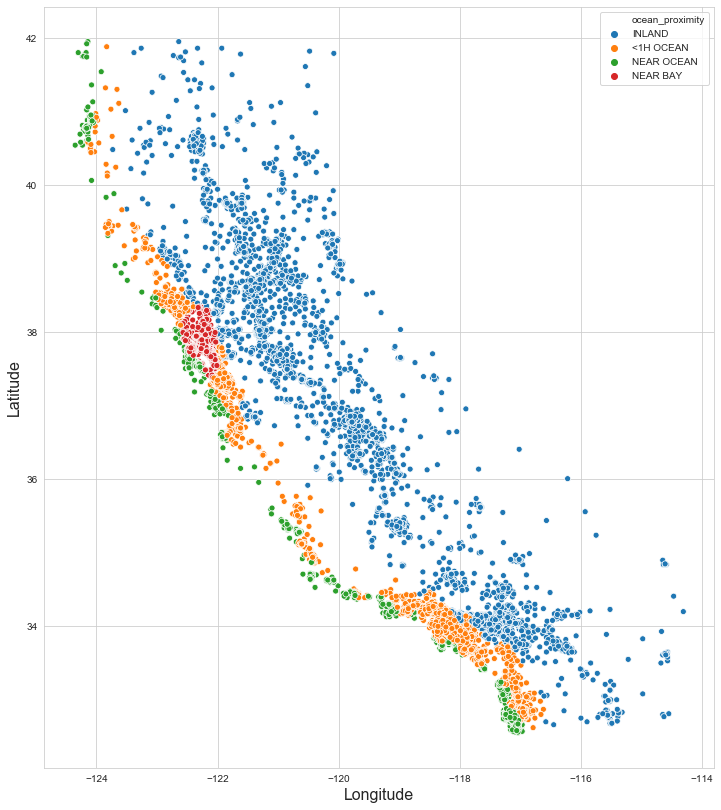

In [17]:
plt.figure(figsize=(12,14))
sns.scatterplot(data=df_train,x="longitude",y="latitude",hue="ocean_proximity")

plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

plt.show()

### Looking for Linear Relationships

In [18]:
## correlations
df_train.corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.642567
med_income_cat        0.613702
total_rooms           0.141802
households            0.095435
total_bedrooms        0.074146
housing_median_age    0.064925
population            0.014881
longitude            -0.049842
latitude             -0.146048
Name: median_house_value, dtype: float64

In [19]:
from pandas.plotting import scatter_matrix

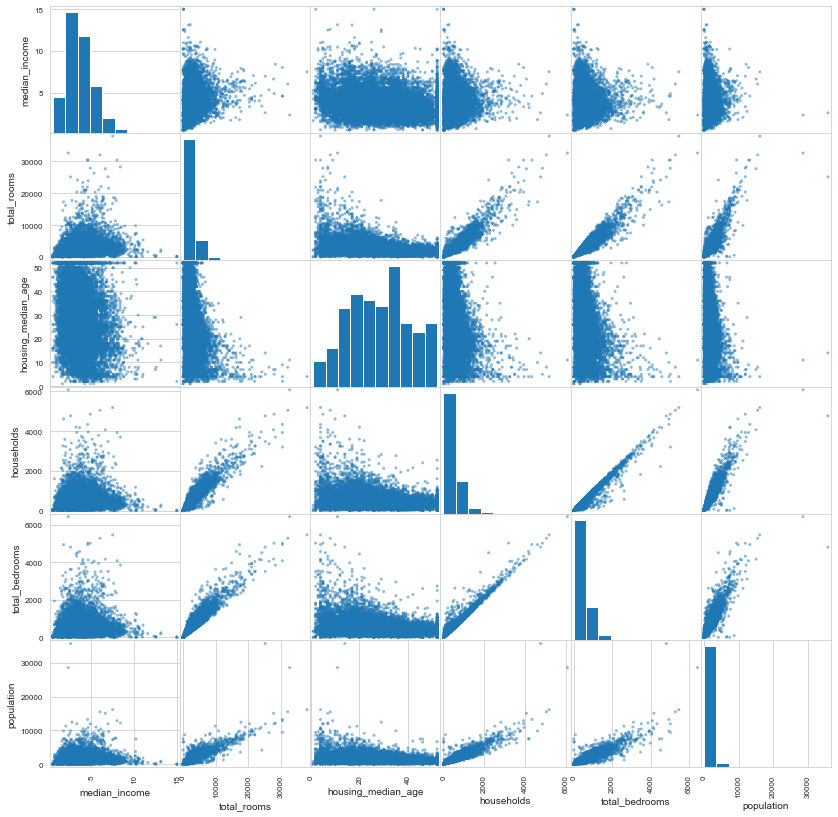

In [20]:
scatter_matrix(df_train[['median_income','total_rooms',
                         'housing_median_age','households',
                         'total_bedrooms','population']], 
                        figsize=(14,14))
plt.show()

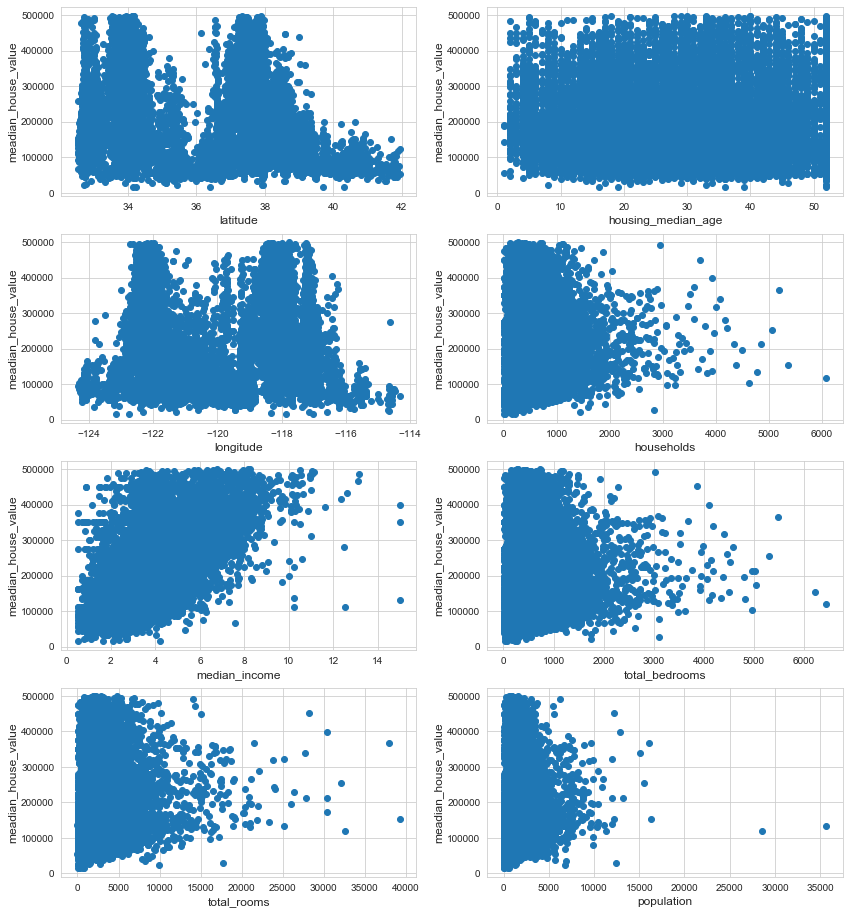

In [21]:
fig, ax = plt.subplots(4,2, figsize=(14,16))

features = ['latitude','longitude','median_income','total_rooms',
            'housing_median_age','households','total_bedrooms','population']

for i in range(len(features)):
    ax[i%4,i//4].scatter(df[features[i]], df.median_house_value)
    ax[i%4,i//4].set_xlabel(features[i], fontsize=12)
    ax[i%4,i//4].set_ylabel("meadian_house_value",fontsize=12)
    
plt.show()

### Exploring Various Transformations of Our Features

It may be the case that some transformations of our features will be better predictors than the features themselves.

In [22]:
# Recasting things as rates
df_train['rooms_per_household'] = df_train["total_rooms"]/df_train["households"]
df_train['bedrms_per_house'] = df_train["total_bedrooms"]/df_train["households"]
df_train['bedrooms_per_room'] = df_train["total_bedrooms"]/df_train["total_rooms"]
df_train['population_per_house'] = df_train["population"]/df_train["households"]
df_train['beds_per_person'] = df_train['total_bedrooms']/df_train['population']

# a longitude latitude transforms
df_train['long_lat'] = df_train['longitude']*df_train['latitude']
df_train['lat_sq'] = df_train['latitude']**2
df_train['long_sq'] = df_train['longitude']**2

# Performing log transforms
df_train['log_households'] = np.log(df_train['households'])
df_train['log_beds'] = np.log(df_train['total_bedrooms'])
df_train['log_rooms'] = np.log(df_train['total_rooms'])
df_train['log_population'] = np.log(df_train['population'])

df_train.corr()['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.642567
med_income_cat          0.613702
log_rooms               0.168767
total_rooms             0.141802
rooms_per_household     0.111700
log_households          0.107747
long_lat                0.105259
households              0.095435
log_beds                0.083306
total_bedrooms          0.074146
housing_median_age      0.064925
long_sq                 0.049688
beds_per_person         0.048355
log_population          0.024509
population              0.014881
population_per_house   -0.018899
longitude              -0.049842
bedrms_per_house       -0.056103
latitude               -0.146048
lat_sq                 -0.149821
bedrooms_per_room      -0.218352
Name: median_house_value, dtype: float64

## Building a Model

From our explatory data analysis it looks like a reasonable thing to do would be to build a model using `median_income`, `bedrooms_per_room`, and `ocean_proximity`.

Let's set up a preprocessing procedure before we fit our model.

### First Imputing Missing Data

We should first address how we'll handle missing data.

With the missing data in the `total_bedrooms` column we have three options.
<ol>
    <li>We can delete the missing rows. This is usually okay if we have a small number of missing rows. It is not the approach we will take here.</li>
    <li>We can ignore the column. This is bad for us since we want to use `bedrooms_per_room`.</li>
    <li>We can fill in the missing values using some statistical procedure, this is called <i>imputation</i>. This is the path we'll take, our "statistical procedure" will just be filling with the median. To do this we use `SimpleImputer` from `sklearn.impute`.</li>
</ol>

### Then Make a Custom Feature Transformer

We'll make a function called get_features.

### Then Scale the Data

We'll use `StandardScaler`.

### Finally Fit the Model

We'll stick with `LinearRegression` for now.


### How to Make a Proper Pipeline to Accomplish These Tasks

Up to this point in the course we've only built pipelines to handle a single type of data. However in this model we'll want to handle both quantitative and qualitative data. Here's where the problem comes in, what does it mean to apply `StandardScaler` to a one hot encoded column? Does that make sense?

That example only illustrates our need to be more careful with our pipelines, otherwise our models will be utter nonsense.

For this model we'll need:
<ul>
    <li>To make a custom imputer that only imputes total_bedrooms, and</li>
    <li>To make a custom scaler that only scales bedrooms_per_room and median_income.</li>
</ul>
We can still use FunctionTransformer and get_features to produce the columns we want.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

In [24]:
# define our preprocessing function
# This creates bedrooms_per_room
# and one hot encodes ocean_proximity
def get_features(df):
    df_copy = df.copy()
    df_copy['bedrooms_per_room'] = df_copy['total_bedrooms']/df_copy['total_rooms']
    
    hot_encoding = pd.get_dummies(df_copy['ocean_proximity'])
    df_copy[hot_encoding.columns] = hot_encoding
    
    features = ['median_income','bedrooms_per_room']
    features.extend(hot_encoding.columns[0:3])
    
    return df_copy[features]

#### How to Make Custom Transformers

At each step of a `Pipeline` we add a transformer object. For example `StandardScaler` and `PolynomialFeatures` take the data and transform it into something else before passing it down the pipe.

`sklearn` is quite nice because it gives us the functionality to make custom transformers relatively easily. To do this we make our own transformer object. To fully grasp everything going on check out my notebook on python objects here, <a href="https://github.com/matthewosborne71/MastersHeadstartPython/blob/master/ClassNotes/Objects.ipynb">https://github.com/matthewosborne71/MastersHeadstartPython/blob/master/ClassNotes/Objects.ipynb</a>, if you're happy just copying and pasting the code for your own transformers (no shame in that for now, we're learning a lot of data science) no need to read through those notes.

Below we go through two examples of how to make custom transformer objects. Each object must have a `fit` and a `transform` method. 

In [25]:
# Define our custom imputer
class BedroomImputer(BaseEstimator, TransformerMixin):
    #Class Constructor 
    # This allows you to initiate the class when you call
    # BedroomImputer
    def __init__(self):
        # I want to initiate each object with
        # the SimpleImputer method
        self.SimpleImputer = SimpleImputer(strategy = "median")
    
    # For my fit method I'm just going to "steal"
    # SimpleImputer's fit method using only the
    # 'total_bedrooms' column
    def fit(self, X, y = None ):
        self.SimpleImputer.fit(X['total_bedrooms'].values.reshape(-1,1))
        return self
    
    # Now I want to transform the total_bedrooms columns
    # and return it with imputed values
    def transform(self, X, y = None):
        X['total_bedrooms'] = self.SimpleImputer.transform(X['total_bedrooms'].values.reshape(-1,1))
        return X

In [26]:
# Define our custom scaler
class NumericScale(BaseEstimator, TransformerMixin):
    # Class Constructor
    # Here I want each NumericScale object to have
    # the StandardScaler method
    def __init__(self):
        self.StandardScaler = StandardScaler()
        
    # Again I piggy back off of StandardScaler's
    # built in fit method
    # only using bedrooms_per_room and median_income
    def fit(self, X, y=None):
        self.StandardScaler.fit(X[['bedrooms_per_room','median_income']])
        return self
    
    # Transform those columns of X so they are scaled
    # then return X
    def transform(self, X, y = None):
        X[['bedrooms_per_room','median_income']] = self.StandardScaler.transform(X[['bedrooms_per_room','median_income']])
        return X

In [27]:
# We can now put it all together in a pipeline
# first impute total_bedrooms
# Then we can select the features we need
# then scale bedrooms_per_room and median_income
# finally we fit the regression model
pipe = Pipeline([('impute',BedroomImputer()),
                ('get_features',FunctionTransformer(get_features)),
                ('scale',NumericScale()),
                ('reg',LinearRegression(copy_X = True))])

In [28]:
# Define X_train and y_train
X_train = df_train[['total_rooms','total_bedrooms','median_income','ocean_proximity']].copy()
y_train = df_train[['median_house_value']].copy()

# Define X_test and y_test
X_test = df_test[['total_rooms','total_bedrooms','median_income','ocean_proximity']].copy()
y_test = df_test[['median_house_value']].copy()

In [29]:
# Fit the model
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('impute', BedroomImputer()),
                ('get_features',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function get_features at 0x1a23dda170>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('scale', NumericScale()),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### Testing and Training RMSE

Let's get a sense of how far off our model is from the actual median house value. One way to do this is to use the root MSE. This takes the MSE and puts it back in the original units of the target. For instance a RMSE of $10$ would indicate that on average our predictions are about $\$10$ off from the true value.

We'll calculate this on both the training and test data. Note if this was a real assignment from my job I probably wouldn't touch the test set this early. However, we will not be building another model in this notebook so we might as look at the test error.

In [30]:
# calculate the training residuals
train_res = pipe.predict(X_train) - y_train.values

# calculate the test residuals
test_res = pipe.predict(X_test) - y_test.values

In [31]:
# Now calculate the RMSE for training data
print("The training RMSE is",
     np.round(np.sqrt( np.sum(np.power(train_res,2))/len(train_res) ),2) )

print()

# Now calculate the RMSE for test data
print("The testing RMSE is",
     np.round(np.sqrt( np.sum(np.power(test_res,2))/len(test_res) ),2) )

The training RMSE is 64287.71

The testing RMSE is 63380.32


### Hypothetical Next Steps

We didn't do so bad here, even with our relatively simple model.

However, there is certainly more we could do to improve this sort of baseline model.

We could look at building ridge, lasso, or elastic net models.

We could create more informative features like distance to a major city.

We could research spatial statistics models. This would help greatly with the fact that our residuals are almost certainly not independent across space. These models help adjust for that by modeling the covariance matrix of the data in addition to the expected value of `median_house_value`.

There are many more directions you could go in building the best model, but we've certainly covered a nice set of techniques to start you along in regression projects.